## **Задание №3** 🚀

<details>
<summary>Нажмите, чтобы раскрыть задание... 🔍</summary>

#### 🔧 **Построить более сложную модель с подбором гиперпараметров:** 

1. **Выбор модели** — **1 балл**:
   -  Использование сложной ML-модели (например, градиентного бустинга или случайного леса).

2. **Подбор гиперпараметров**:
   -  С использованием методов scikit-learn на кросс-валидации — **2 балла**.
   -  С использованием библиотеки Optuna на кросс-валидации — **3 балла**.

3. **Обучение модели с лучшими гиперпараметрами** — **2 балла**:
   -  Финальное обучение модели с использованием подобранных гиперпараметров.

4. **Оценка модели на отложенной выборке** — **1 балл**:
   - Оценка качества модели с использованием выбранной метрики (например, R², MAE).


#### 🧐 **Проинтерпретировать полученную модель:**

1. **Интерпретация модели** — **4 балла**:
   -  Включение визуализаций (например, коэффициенты модели, permutation importances, LIME, SHAP).

2. **Экспертное мнение** — **4 балла**:
   -  Оценка адекватности признаков и решений, принимаемых моделью, в 1–2 предложениях.


#### ✅ **Общие требования:** 

1. **Воспроизводимость решения** — **3 балла**:
   -  Зафиксированы `random_state`.
   -  Ноутбук полностью воспроизводится без ошибок.

2. **Соблюдение code style** — **4 балла**:
   -  Код соответствует стандартам PEP8.
   -  Структура ноутбука следует рекомендациям "On Writing Clean Jupyter Notebooks".

3. **Обоснование принимаемых решений** — **6 баллов**:
   -  Все шаги и решения подробно прокомментированы в markdown-ячейках.
   -  Например, объяснено, почему была выбрана конкретная модель и какие гиперпараметры оптимизировались.

</details>

### Импорт необходимых библиотек

In [44]:
# Работа с данными и визуализация
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Предобработка данных и построение пайплайнов
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

# Модели и метрики
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Кросс-валидация, оптимизация и прогресс
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.inspection import permutation_importance
import optuna
from optuna.samplers import TPESampler

### Разбиение датасета 

In [16]:
# Подгрузка датасета 
df = pd.read_csv('../data/housing.csv')
# Целевая переменная
y = df['median_house_value']

# Признаки (все столбцы, кроме 'median_house_value')
X = df.drop(columns=['median_house_value'])
X = X.dropna()

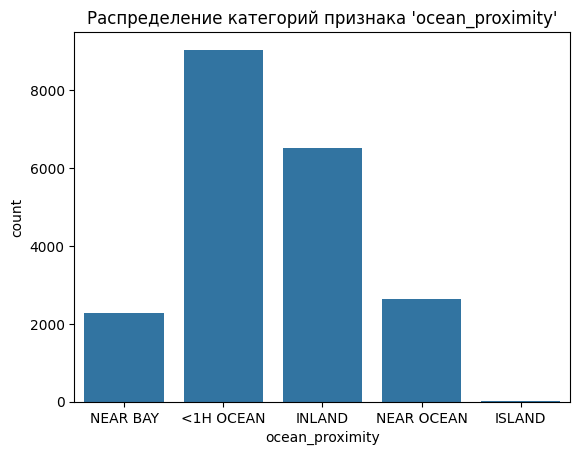

In [17]:
# Пример для категориального признака
sns.countplot(data=X, x='ocean_proximity')
plt.title("Распределение категорий признака 'ocean_proximity'")
plt.show()

In [18]:
# Удаляем строки с 'ocean_proximity' == 'ISLAND'
X = X[X['ocean_proximity'] != 'ISLAND']
y = y[X.index]

y = y.loc[X.index]  # Убедитесь, что целевая переменная `y` синхронизирована

# Разделяем на тренировочную и тестовую выборки (80% на тренировочную, 20% на тестовую) + стратификация
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.2, stratify=X['ocean_proximity'])

print(f'Размер датасета : {df.shape}')
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер датасета : (20640, 10)
Размер тренировочной выборки: (16342, 9)
Размер тестовой выборки: (4086, 9)


### Улучшение модели без переобучения
Я проделала много экспериментов прежде чем прийти к дальнейшему пайплайну, вот проблема с которой я столкнулась:
1. **Проблема:** 
   Разница в метрике \(R^2\) между тренировочными (0.95) и тестовыми (0.84) данными указывает на умеренную степень переобучения (в принципе допустимую, но хотелось бы результаты чуть лучше). Это также отслеживалось в процессе, когда разница метрик на валидационных данных и выброчных была значительной (а нужно так – чем меньше, тем лучше)

2. **Решения:**
   - **Удаление коррелирующих признаков:** 
     Убраны `total_bedrooms`, `total_rooms`, `population`, `households` на основании анализа корреляции.
   - **Обработка редких категорий:** 
     В столбце `ocean_proximity` исключена редкая категория `Island` (только 5 значений).
   - **Стратификация:**
     Выполнена по значимому категориальному признаку `<1H OCEAN`, чтобы распределение было сбалансированным.
   - **Географические координаты:**
     Сохранила признаки `longitude` и `latitude`, так как они описывают местоположение и не могут быть исключены, несмотря на корреляцию.

3. **Результат:**
   Удаление избыточных признаков уменьшило переобучение, позволив улучшить метрику на тестовых данных, сохраняя значимость модели.

(вот все признаки и расчет корреляции)
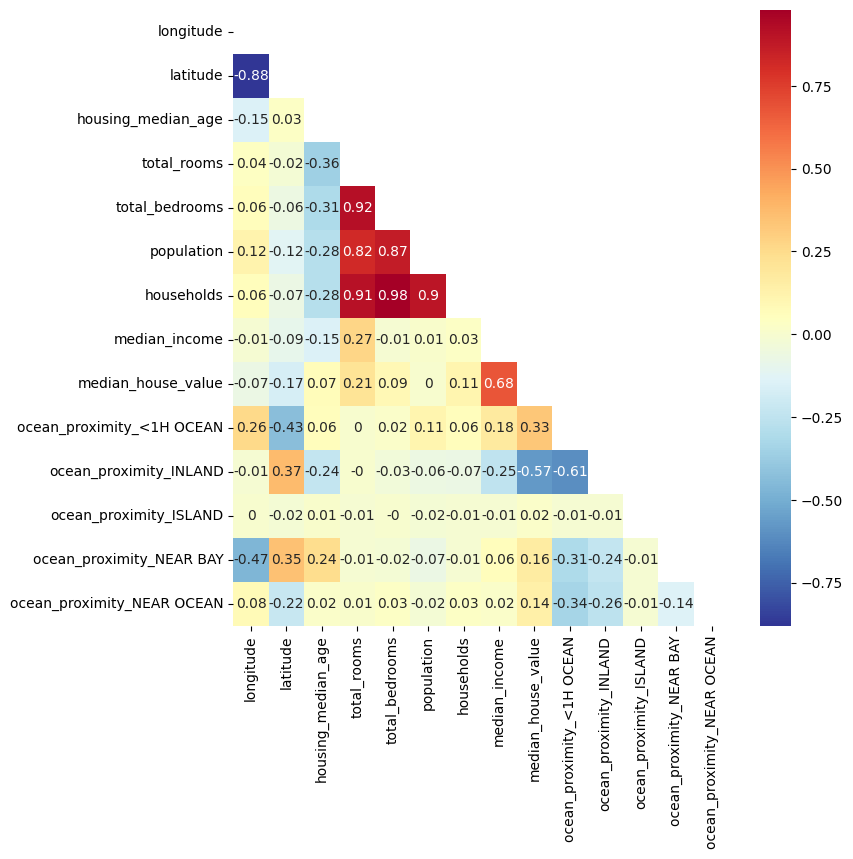

In [19]:
# Удаление коррелирующих признаков
X_train = X_train.drop(columns=['total_bedrooms', 'households'])
X_test = X_test.drop(columns=['total_bedrooms', 'households'])

### Описание пайплайна и выбор модели

#### Эксперименты:
1. **RandomForestRegressor**:
   - Метрика (R^2 ~ 0.83), низкая точность.
2. **GradientBoostingRegressor**:
   - (R^2 ~ 0.8412), но обучение заняло ~30 минут  (даже с параллельным выполнением на ядрах и подбором оптимальных гиперпараметров).

#### Почему LightGBM:
1. **Скорость и эффективность:** Быстрое обучение.
2. **Работа с пропусками и категориями:** Нативная поддержка категориальных данных и пропусков (да, она не очень, но зато есть, что позволяет запусить сразу и протестировать модель).
3. **Гибкость настройки:** Параметры, такие как `num_leaves` и `learning_rate`, легко адаптируются под данные.
4. **Интерпретируемость:** Предоставляет важность признаков.

#### Итог:
**`LGBMRegressor`** выбрана за сочетание скорости и качества, что делает её оптимальной для текущей задачи.


### Настройка пайплайна для модели **`LGBMRegressor`**

In [30]:
# Функция обработки выбросов
def clip_iqr(X):
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(X, lower_bound, upper_bound)

# Пайплайн для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('iqr', FunctionTransformer(func=clip_iqr, validate=False)),
    ('scaler', RobustScaler())
])

# Пайплайн для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))     # One-Hot Encoding
])

# Препроцессор для обработки как числовых, так и категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=['int64', 'float64'])),
        ('cat', categorical_transformer, make_column_selector(dtype_include=['object', 'category']))
    ]
)

# Модель и пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=21, n_jobs=-1, verbosity=-1))
])

### Описание пайплайна и обработка категориальных данных

Пайплайн настроен для корректной обработки данных и соответствия требованиям модели **`LGBMRegressor`**:

#### **1. Обработка данных**
- **Числовые признаки:**
  - **Обработка выбросов** (`clip_iqr`) уменьшает влияние экстремальных значений.
  - **Масштабирование** (`RobustScaler`) учитывает выбросы и делает данные интерпретируемыми.

- **Категориальные признаки:**
  - Прямое использование категорий (`category`) поддерживается `LGBMRegressor`.
  - Также протестировано кодирование с помощью **OneHotEncoder (OHE)**.

#### **2. Анализ кодирования категориальных данных**
- **Особенность модели:**  
  `LGBMRegressor` поддерживает категориальные данные в формате `category`, исключая необходимость кодирования. Однако в рамках экспериментов были протестированы оба подхода.

- **Результаты:**
  - **Без кодирования:**  
    - \(MAE = 31729.786\), \(MSE = 2198323779.286\), \(R^2 = 0.83154\).
  - **С OHE:**  
    - \(MAE = 29666.611\), \(MSE = 2015715721.838\), \(R^2 = 0.84553\).

- **Вывод:**  
  OneHot Encoding улучшил метрику \(R^2\), но увеличил размерность данных. Остальные методы кодирования не показали значимых улучшений + при тетстировании другие параметры не менялись, проверялось только влияение кодирования.

#### **3. Преимущества выбранного подхода**
- Пайплайн минимизирует шум и выбросы.
- Обеспечивает гибкость в работе с числовыми и категориальными признаками.

**Итог:**  
Пайплайн оптимизирован для работы с `LGBMRegressor`. Кодирование категорий через OHE показало лучшие результаты

In [31]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('iqr',
                                                                   FunctionTransformer(func=<function clip_iqr at 0x175eb13f0>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3320bf760>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3320bf6a0>)])),
                ('model',
                 LGBMRegressor(n_jobs=-1, random_state=21, verbosity=-1))])

#### Подбор гиперпараметров с использованием методов scikit-learn на кросс-валидации
Для оптимизации гиперпараметров модели был использован метод `GridSearchCV` из библиотеки scikit-learn. Этот метод проводит подбор параметров на основе кросс-валидации, что обеспечивает стабильную оценку качества и помогает избежать переобучения.

В качестве параметров для подбора были выбраны ключевые гиперпараметры модели **`LGBMRegressor`**, влияющие на её производительность:
- **Количество деревьев в ансамбле (`n_estimators`):** 700, 800.
- **Скорость обучения (`learning_rate`):** 0.05, 0.1.
- **Максимальная глубина деревьев (`max_depth`):** 8, 10.
- **Доля подвыборки (`subsample`):** 0.4, 0.6.
- **Количество листьев дерева (`num_leaves`):** 31, 33.

Для оценки качества использовалась метрика коэффициента детерминации (`r²`), а разделение данных на тренировочные и валидационные выполнялось с помощью 10-фолдовой кросс-валидации (`cv=5`). Параллельная обработка (`n_jobs=-1`) ускоряла процесс подбора.

По результатам подбора были определены гиперпараметры, которые обеспечили максимальное значение метрики `r²` на тренировочной выборке. Финальная модель была протестирована на тестовых данных, где её качество оценивалось по метрикам `MAE`, `MSE` и `r²`.

In [32]:
# Сетка гиперпараметров для GridSearch
param_grid_gs = {
    'model__n_estimators': [600, 800],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [8, 10],
    'model__subsample': [0.4, 0.6],
    'model__num_leaves': [31, 33],
}

# Кросс-валидатор с random_state для GridSearch
cv_gs = KFold(n_splits=5, shuffle=True, random_state=21)

# Настройка метрик для оценки в GridSearch
scoring_gs = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error'
}

# Настройка GridSearchCV
grid_search_gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_gs,
    scoring=scoring_gs,
    cv=cv_gs,
    verbose=1,       # Полностью отключает вывод
    n_jobs=-1,       # Параллельная обработка
    refit='r2'       # Лучшая модель по метрике R²
)

# Обучение модели через GridSearch
grid_search_gs.fit(X_train, y_train)

# Лучшие параметры и метрика R² из GridSearch
best_params_gs = grid_search_gs.best_params_
best_score_gs = grid_search_gs.best_score_

print(f"Лучшие параметры (GridSearch): {best_params_gs}")
print(f"Лучшая метрика R² (GridSearch): {best_score_gs:.4f}")

# Метрики на тренировочной выборке (GridSearch)
y_train_pred_gs = grid_search_gs.best_estimator_.predict(X_train)
train_mse_gs = mean_squared_error(y_train, y_train_pred_gs)
train_r2_gs = r2_score(y_train, y_train_pred_gs)
train_mae_gs = mean_absolute_error(y_train, y_train_pred_gs)

# Метрики на тестовой выборке (GridSearch)
y_test_pred_gs = grid_search_gs.best_estimator_.predict(X_test)
test_mse_gs = mean_squared_error(y_test, y_test_pred_gs)
test_r2_gs = r2_score(y_test, y_test_pred_gs)
test_mae_gs = mean_absolute_error(y_test, y_test_pred_gs)

# Вывод метрик (GridSearch)
header_gs = f"{'Выборка':<20}{'MSE':>20}{'MAE':>20}{'R²':>10}"
separator_gs = "-" * len(header_gs)
train_row_gs = f"{'Тренировочная (GS)':<20}{train_mse_gs:>20,.3f}{train_mae_gs:>20,.3f}{train_r2_gs:>10.5f}"
test_row_gs = f"{'Тестовая (GS)':<20}{test_mse_gs:>20,.3f}{test_mae_gs:>20,.3f}{test_r2_gs:>10.5f}"

print("\nРезультаты метрик для модели (GridSearch):")
print(header_gs)
print(separator_gs)
print(train_row_gs)
print(test_row_gs)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Лучшие параметры (GridSearch): {'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 800, 'model__num_leaves': 33, 'model__subsample': 0.4}
Лучшая метрика R² (GridSearch): 0.8436

Результаты метрик для модели (GridSearch):
Выборка                              MSE                 MAE        R²
----------------------------------------------------------------------
Тренировочная (GS)       937,502,825.041          20,893.014   0.92997
Тестовая (GS)          2,026,799,608.352          29,860.040   0.84468


### Итоги подбора гиперпараметров

Подбор гиперпараметров с использованием **5-фолдовой кросс-валидации** позволил определить следующие оптимальные значения:

- **learning_rate**: 0.05  
- **max_depth**: 10  
- **n_estimators**: 800  
- **num_leaves**: 33  
- **subsample**: 0.4  

#### Результаты оценки модели:
- **На валидационной выборке**:  
  - (R^2 = 0.8436)

- **На тестовой выборке**:  
  - **MSE**: 2,026,799,608.35  
  - **MAE**: 29,860.04  
  - (R^2 = 0.8447)

- **На тренировочной выборке**:  
  - **MSE**: 937,502,825.04  
  - **MAE**: 20,893.01  
  - (R^2 =  0.92997)

#### Вывод:
Результаты показывают, что модель **`LGBMRegressor`** демонстрирует хорошую обобщающую способность. Разница между метриками на тренировочной и тестовой выборках минимальна (для метрики разница R^2 = 0,08529), что свидетельствует об отсутствии переобучения. Модель успешно справляется с задачей.

А теперь попробуем протестировать с использованием Optuna
___

### Оптимизация гиперпараметров с использованием Optuna

Для настройки модели применён фреймворк **Optuna**, использующий алгоритм TPE (Tree-structured Parzen Estimator) для поиска лучших параметров. 

1. Настроена целевая функция (`objective`), которая оптимизирует метрику \(R^2\) на кросс-валидации.  
2. Подбирались параметры:
   - Количество деревьев (`n_estimators`).
   - Скорость обучения (`learning_rate`).
   - Глубина деревьев (`max_depth`).
   - Подвыборка данных (`subsample`).
   - Количество листьев (`num_leaves`).
3. Применена 5-фолдовая кросс-валидация для оценки качества.  
4. Итоговая модель протестирована на тестовой выборке.

In [27]:
# Функция для Optuna
def objective(trial):
    # Гиперпараметры для подбора
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.9, step=0.4),
        'max_depth': trial.suggest_int('max_depth', 4, 10, step=2),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8, step=0.1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 33)
    }

    # Создаем модель с текущими параметрами
    model = LGBMRegressor(random_state=21, n_jobs=-1, **params)

    # Объединяем модель в пайплайн
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Кросс-валидация
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
        pipeline.fit(X_train_cv, y_train_cv)
        y_pred = pipeline.predict(X_val_cv)
        scores.append(r2_score(y_val_cv, y_pred))

    # Возвращаем средний R² по фолдам
    return np.mean(scores)

# Создание Optuna-исследования
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=21))
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Лучшие параметры
best_params = study.best_params
best_score = study.best_value

print(f"Лучшие параметры: {best_params}")
print(f"Лучшая метрика R²: {best_score:.4f}")

# Оценка на тестовой выборке
best_model = LGBMRegressor(random_state=21, n_jobs=-1, **best_params)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# Обучение модели на всех тренировочных данных
pipeline.fit(X_train, y_train)

# Метрики на тренировочной выборке
y_train_pred = pipeline.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Метрики на тестовой выборке
y_test_pred = pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Красивый вывод метрик
header = f"{'Выборка':<20}{'MSE':>20}{'MAE':>20}{'R²':>10}"
separator = "-" * len(header)
train_row = f"{'Тренировочная':<20}{train_mse:>20,.3f}{train_mae:>20,.3f}{train_r2:>10.5f}"
test_row = f"{'Тестовая':<20}{test_mse:>20,.3f}{test_mae:>20,.3f}{test_r2:>10.5f}"

print("\nРезультаты метрик для модели:")
print(header)
print(separator)
print(train_row)
print(test_row)

[I 2024-12-31 17:58:29,086] A new study created in memory with name: no-name-db918970-0a06-4394-aa83-4764582654d0


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-12-31 17:58:36,224] Trial 0 finished with value: 0.8423456876339463 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 8, 'subsample': 0.4, 'num_leaves': 31}. Best is trial 0 with value: 0.8423456876339463.
[I 2024-12-31 17:58:43,265] Trial 1 finished with value: 0.8410338923313774 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 8, 'subsample': 0.5, 'num_leaves': 32}. Best is trial 0 with value: 0.8423456876339463.
[I 2024-12-31 17:58:46,250] Trial 2 finished with value: 0.7837140671480473 and parameters: {'n_estimators': 500, 'learning_rate': 0.9, 'max_depth': 4, 'subsample': 0.4, 'num_leaves': 32}. Best is trial 0 with value: 0.8423456876339463.
[I 2024-12-31 17:59:01,690] Trial 3 finished with value: 0.7399846306961715 and parameters: {'n_estimators': 1100, 'learning_rate': 0.9, 'max_depth': 10, 'subsample': 0.7000000000000001, 'num_leaves': 32}. Best is trial 0 with value: 0.8423456876339463.
[I 2024-12-31 17:59:11,701] Trial 4

### Вывод по подбору гиперпараметров с использованием Optuna

Сразу стоить заметить, что плюс Optuna - оптимизированный подбор лучших параметров. Это значит, что не нужно перебирать все параметры, алгоритм Optuna позволяет за короткое вреся рассмотреть только потенциально лучшие варианты. 

В результате оптимизации гиперпараметров с помощью Optuna были выбраны следующие параметры:
- **Количество деревьев в ансамбле (`n_estimators`):** 600  
- **Скорость обучения (`learning_rate`):** 0.1  
- **Максимальная глубина деревьев (`max_depth`):** 8  
- **Доля подвыборки данных (`subsample`):** 0.4  
- **Количество листьев в дереве (`num_leaves`):** 31  

#### Метрики на тренировочной выборке:
- **MSE (Mean Squared Error):** 775,337,225.557  
- **MAE (Mean Absolute Error):** 19,067.547  
- **R² (Coefficient of Determination):** 0.94208  

#### Метрики на тестовой выборке:
- **MSE (Mean Squared Error):** 2,039,774,690.554  
- **MAE (Mean Absolute Error):** 29,859.628  
- **R² (Coefficient of Determination):** 0.84369  

Модель показала высокое качество на тренировочной выборке (\(R^2 = 0.94208\)) и хорошую обобщающую способность на тестовых данных (\(R^2 = 0.84369\)), что свидетельствует о сбалансированности обучения.



---

### Сравнение результатов Optuna и GridSearch

| **Метод**       | **learning_rate** | **max_depth** | **n_estimators** | **num_leaves** | **subsample** | **Тренировочная MSE** | **Тренировочная MAE** | **Тренировочный R²** | **Тестовая MSE** | **Тестовая MAE** | **Тестовый R²** |
|------------------|-------------------|---------------|------------------|----------------|---------------|------------------------|-----------------------|----------------------|------------------|-----------------|----------------|
| **GridSearch**  | 0.05              | 10            | 800              | 33             | 0.4           | 937,502,825.04        | 20,893.01            | 0.92997              | 2,026,799,608.35 | 29,860.04       | 0.8447         |
| **Optuna**       | 0.1               | 8             | 600              | 31             | 0.4           | 775,337,225.56        | 19,067.55            | 0.94208              | 2,039,774,690.55 | 29,859.63       | 0.84369        |

### Выводы:
1. **Optuna** показала лучшее качество на тренировочной выборке с меньшим MSE и MAE, а также более высоким \(R^2\), что указывает на лучшее обучение модели.
2. На тестовой выборке результаты **GridSearch** и **Optuna** практически идентичны. GridSearch показал чуть лучшее значение \(R^2\) (0.8447 против 0.84369), но разница незначительна.
3. Однако, модель, настроенная с помощью **Optuna**, показала более высокое значение \( R^2 \) на тренировочной выборке (0.94208 против 0.92997 у GridSearch), но разница между тренировочной и тестовой выборками была больше (0.09839 против 0.08527), что свидетельствует о большем переобучении. **GridSearch**, напротив, обеспечил более сбалансированные результаты с меньшей разницей между \( R^2 \) тренировочной и тестовой выборок, что делает её предпочтительнее для задач, где важна устойчивость модели.

---

### Интерпретация модели

Для интерпретации модели RandomForestRegressor, полученной в предыдущем пункте, можно использовать следующие подходы:

1. **Важность признаков (Feature Importances):**
   - RandomForest предоставляет встроенные значения важности признаков, которые показывают, насколько каждый из признаков влияет на предсказания модели.

2. **Permutation Importances:**
   - Более точный способ оценки важности признаков, основанный на случайной перестановке значений признака и измерении снижения качества модели.


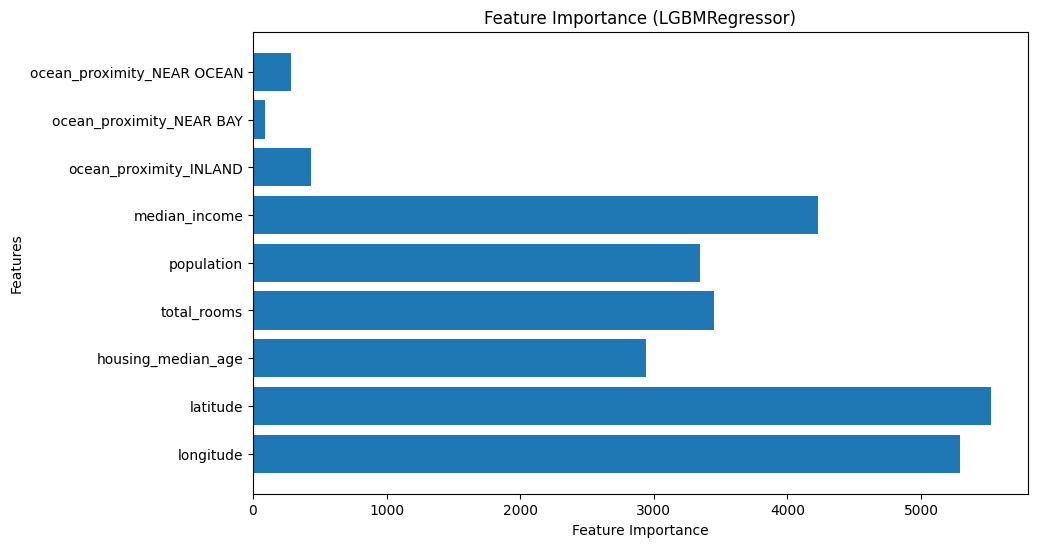

In [42]:
# Важность признаков
feature_importances = grid_search_gs.best_estimator_.named_steps['model'].feature_importances_

# Имена числовых признаков
numeric_feature_names = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Имена категориальных признаков после OHE
categorical_encoder = grid_search_gs.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = categorical_encoder.get_feature_names_out(X_train.select_dtypes(include=['object', 'category']).columns)

# Комбинирование имен всех признаков
feature_names = numeric_feature_names + list(categorical_feature_names)

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance (LGBMRegressor)")
plt.show()

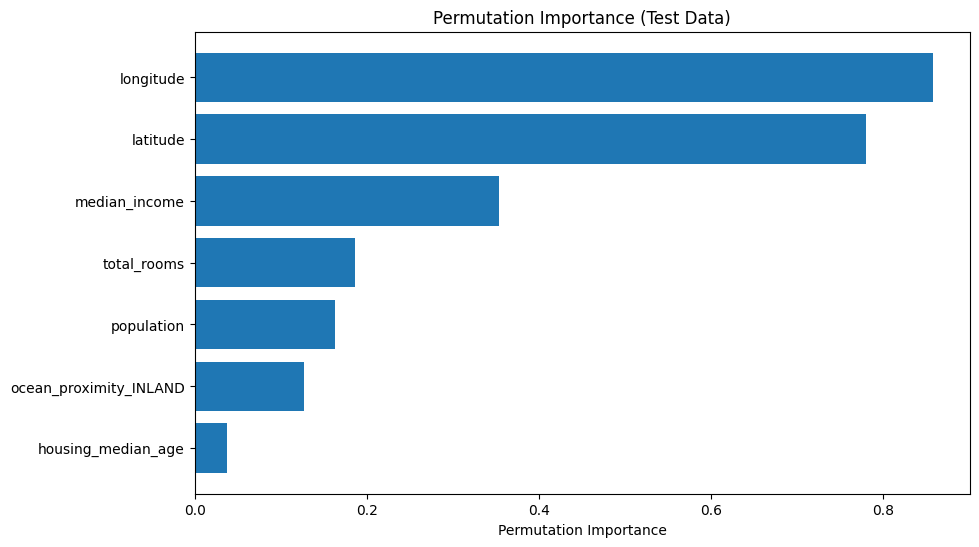

In [43]:


# Расчет Permutation Importance
result = permutation_importance(
    grid_search_gs.best_estimator_,
    X_test,
    y_test,
    scoring='r2',
    n_repeats=10,
    random_state=21
)

# Сортировка по важности
sorted_idx = result.importances_mean.argsort()

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance (Test Data)")
plt.show()

### Выводы по графикам важности признаков

1. **Feature Importances (Важность признаков):**
   - **Самые значимые признаки:**
     - latitude и longitude: наибольшая важность, что указывает на сильное влияние географического положения на целевую переменную.
     - median_income: один из ведущих факторов, подчеркивающий значимость дохода для предсказаний.
   - **Умеренная значимость:**
     - population, total_rooms, housing_median_age: средний вклад в предсказания, что может отражать влияние этих факторов на характеристики жилой среды.
   - **Наименее значимые признаки:**
     - ocean_proximity_NEAR BAY, ocean_proximity_NEAR OCEAN: минимальная важность, что может указывать на низкую предсказательную силу информации о близости к океану.

2. **Permutation Importances (Важность на основе перестановок):**
   - longitude и latitude имеют наибольшее влияние на модель, подтверждая, что географические координаты играют ключевую роль в предсказаниях.
   - median_income и total_rooms также важны, что подтверждает их значимость в задаче прогнозирования.
   - ocean_proximity_INLAND и housing_median_age имеют меньший вклад, что указывает на их меньшую значимость в контексте этой задачи.
   
Таким образом, можно заключить, что географические признаки (широта и долгота) имеют наибольшее влияние на предсказания модели, что логично для задач, связанных с недвижимостью и ее расположением. Единственное, я ожидала большего влияния от категориальных признаков.

### Экспертное мнение

Модель правильно выделяет основные признаки, которые важны для предсказания цен на недвижимость, такие как **latitude**, **longitude**, **median_income** и **total_rooms**.

Географические координаты, такие как **latitude** и **longitude**, оказались самыми важными, что вполне логично для задач, связанных с расположением недвижимости, особенно если речь идет о курортных районах. Вот только признаки, связанные с **ocean_proximity** (например, **ocean_proximity_NEAR BAY** и **ocean_proximity_NEAR OCEAN**), сыграли минимальную роль в предсказаниях, что немного удивляет, потому что я ожидала, что близость к океану будет также важна. Но в целом, модель адекватно использует **географию** для прогнозов.

Кроме того, такие признаки, как **median_income** и **total_rooms**, тоже важны для модели, подчеркивая влияние **социально-экономических факторов** и характеристик жилого пространства на точность предсказаний.

Визуализация: Результаты предсказания (модель хорошо предсказывает большинство значений, это видно по близости к идеальной красной линии):

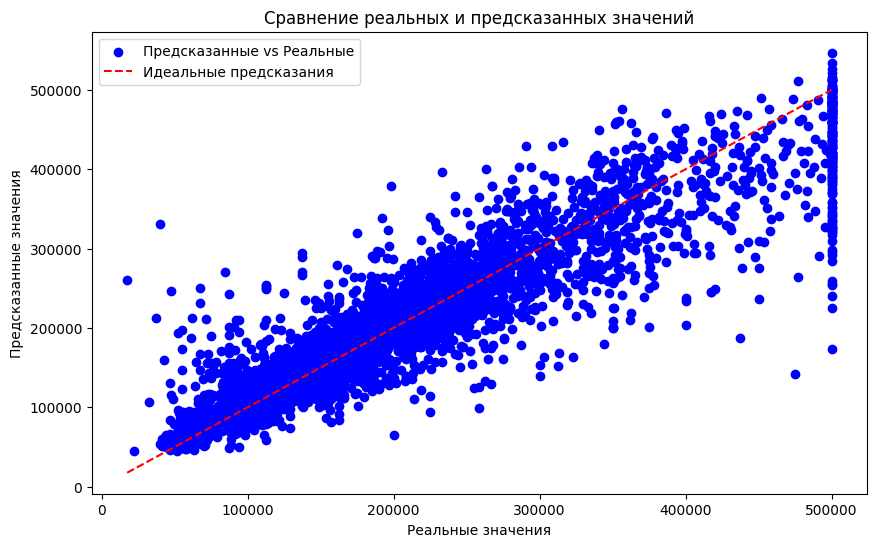